In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim

import gym
import random
import numpy as np
from collections import deque

In [2]:
def mini_batch_train(env, agent, max_episodes, max_steps, batch_size):#小批次訓練
    episode_rewards = []
    best_agent = None

    for episode in range(max_episodes):# episode 代表每一個回合
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps): # step 代表每一個遊戲步驟
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done) #push經驗
            episode_reward += reward

            if len(agent.replay_buffer) > batch_size:#如果累積夠多經驗就更新agent
                agent.update(batch_size)   

            if done or step == max_steps-1:#如果遊戲結束就打印這回合的分數
                episode_rewards.append(episode_reward) # 記錄這回合reward
                print("Episode " + str(episode) + ": " + str(episode_reward))
                # 對這回合agent表現做評估
                if episode_reward >= max(episode_rewards):
                    best_agent = agent # 保存當前最佳agent
                    print('record best agent')
                break

            state = next_state #轉換到下一個狀態

    return episode_rewards,best_agent

In [3]:
class BasicBuffer:

  def __init__(self, max_size):
      self.max_size = max_size
      self.buffer = deque(maxlen=max_size)

  def push(self, state, action, reward, next_state, done):#把經驗push到經驗池
      experience = (state, action, np.array([reward]), next_state, done)
      self.buffer.append(experience)

  def sample(self, batch_size):#從經驗池採樣
      state_batch = []
      action_batch = []
      reward_batch = []
      next_state_batch = []
      done_batch = []

      batch = random.sample(self.buffer, batch_size)

      for experience in batch:
          state, action, reward, next_state, done = experience
          state_batch.append(state)
          action_batch.append(action)
          reward_batch.append(reward)
          next_state_batch.append(next_state)
          done_batch.append(done)

      return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

  def __len__(self):
      return len(self.buffer)

In [4]:
# Ornstein-Ulhenbeck Noise
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [5]:
class Critic(nn.Module):

    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()

        self.obs_dim = obs_dim
        self.action_dim = action_dim

        self.linear1 = nn.Linear(self.obs_dim, 1024)
        self.linear2 = nn.Linear(1024 + self.action_dim, 512)
        self.linear3 = nn.Linear(512, 300)
        self.linear4 = nn.Linear(300, 1)

    def forward(self, x, a):
        x = F.relu(self.linear1(x))
        xa_cat = torch.cat([x,a], 1)
        xa = F.relu(self.linear2(xa_cat))
        xa = F.relu(self.linear3(xa))
        qval = self.linear4(xa)

        return qval#輸出狀態價值

class Actor(nn.Module):

    def __init__(self, obs_dim, action_dim):
        super(Actor, self).__init__()

        self.obs_dim = obs_dim
        self.action_dim = action_dim

        self.linear1 = nn.Linear(self.obs_dim, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, self.action_dim)

    def forward(self, obs):
        x = F.relu(self.linear1(obs))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x#輸出動作

In [6]:
class DDPGAgent:
    
    def __init__(self, env, gamma, tau, buffer_maxlen, critic_learning_rate, actor_learning_rate):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        
        # hyperparameters
        self.env = env
        self.gamma = gamma#折現因子
        self.tau = tau#更新幅度調整項
        
        # initialize actor and critic networks
        self.critic = Critic(self.obs_dim, self.action_dim).to(self.device).apply(self._init_weights)
        self.critic_target = Critic(self.obs_dim, self.action_dim).to(self.device)
        
        self.actor = Actor(self.obs_dim, self.action_dim).to(self.device).apply(self._init_weights)
        self.actor_target = Actor(self.obs_dim, self.action_dim).to(self.device)
    
        # Copy critic target parameters
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # optimizers
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
    
        self.replay_buffer = BasicBuffer(buffer_maxlen)        
        self.noise = OUNoise(self.env.action_space)
    
    # 參數初始化的靜態方法
    @staticmethod
    def _init_weights(m):
        if hasattr(m,'weight'):
            torch.nn.init.xavier_uniform(m.weight)
        if hasattr(m,'bias'):
            m.bias.data.fill_(0)
        
    def get_action(self, obs):
        state = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
        action = self.actor.forward(state)
        action = action.squeeze(0).cpu().detach().numpy()

        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.replay_buffer.sample(batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, masks = self.replay_buffer.sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        masks = torch.FloatTensor(masks).to(self.device)
   
        curr_Q = self.critic.forward(state_batch, action_batch)
        next_actions = self.actor_target.forward(next_state_batch)
        next_Q = self.critic_target.forward(next_state_batch, next_actions.detach())
        expected_Q = reward_batch + self.gamma * next_Q
        
        # update critic # 先更新價值網路
        q_loss = F.mse_loss(curr_Q, expected_Q.detach())

        self.critic_optimizer.zero_grad()
        q_loss.backward() 
        self.critic_optimizer.step()

        # update actor # 再更新動作網路
        policy_loss = -self.critic.forward(state_batch, self.actor.forward(state_batch)).mean()
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

In [7]:
env = gym.make("Pendulum-v0")

max_episodes = 100
max_steps = 500
batch_size = 32

gamma = 0.99 # 對未來的折現
tau = 1e-2 #target net 緩慢變動 讓收斂穩定
buffer_maxlen = 100000 #對抗樣本的相關性,讓樣本彼此間獨立
critic_lr = 1e-3
actor_lr = 1e-3

agent = DDPGAgent(env, gamma, tau, buffer_maxlen, critic_lr, actor_lr)
episode_rewards,agent = mini_batch_train(env, agent, max_episodes, max_steps, batch_size)

C:\Users\skywalker0803r\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\skywalker0803r\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Episode 0: -1757.6532335298145
record best agent
Episode 1: -1203.8731470114144
record best agent
Episode 2: -1753.2307068927869
Episode 3: -1746.9688395977773
Episode 4: -1569.9777087052487
Episode 5: -1388.6737883526644
Episode 6: -1211.4464071963992
Episode 7: -1316.8222019995223
Episode 8: -1334.021345064843
Episode 9: -1295.5488472097193
Episode 10: -1258.6230318227688
Episode 11: -1319.318079228644
Episode 12: -1326.9209970497595
Episode 13: -1306.5361801160589
Episode 14: -1330.5471500954527
Episode 15: -1307.420370731459
Episode 16: -1315.3886377487097
Episode 17: -629.7462672854232
record best agent
Episode 18: -256.70284267020384
record best agent
Episode 19: -931.7862225163566
Episode 20: -988.6521637248201
Episode 21: -628.8612857035471
Episode 22: -252.68110926153034
record best agent
Episode 23: -752.2553990446371
Episode 24: -256.03079531085666
Episode 25: -759.3397919935348
Episode 26: -376.0441778010971
Episode 27: -247.22379612443535
record best agent
Episode 28: -126

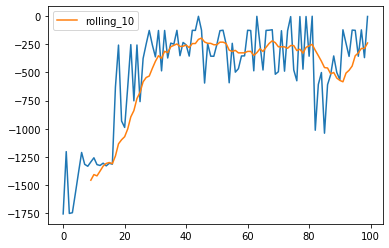

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
plt.plot(episode_rewards)
plt.plot(pd.Series(episode_rewards).rolling(10).mean(),label='rolling_10')
plt.legend()
plt.show()

# enjoy!

In [13]:
observation = env.reset()
for _ in range(1000):
    env.render()
    action = agent.get_action(observation)
    #action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        observation = env.reset()
env.close()

In [10]:
env.close()